In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [2]:
rein_df = pd.read_csv('pcd_vf.csv')

rein_df = rein_df.drop('Column1', axis=1)

print(rein_df.columns)
rein_df

Index(['Gender', 'Age', 'Height (cm)', 'Weight (kg)', 'Living donor',
       'Hemoglobin', 'Leukocyte', 'Serum creatinine', 'Total bilirubin',
       'Albumin', 'Hypertension', 'Diabetes', 'Anemia',
       'Cardiac insufficiency', 'Calcium channel blocker', 'Metoprolol',
       'Omeprazole', 'Furosemide', 'ACEI /ARA*', 'Cephalosporin ', 'Infected',
       'Initial_dose', 'Stable_dose', 'Dose_group', 'CYP1A5 6986AG',
       'ABCB1 3435CT', 'ABCB1 129TC', 'ABCB1 1236CT', 'ABCB1 2677GT'],
      dtype='object')


,Gender,Age,Height (cm),Weight (kg),Living donor,Hemoglobin,Leukocyte,Serum creatinine,Total bilirubin,Albumin,...,Cephalosporin,Infected,Initial_dose,Stable_dose,Dose_group,CYP1A5 6986AG,ABCB1 3435CT,ABCB1 129TC,ABCB1 1236CT,ABCB1 2677GT
0,2.0,37.0,163,52.0,0.0,108.0,4.16,708.0,7.8,43.5,...,1.0,1.0,6.0,1.0,1,3,1,1,2,2
1,1.0,37.0,168,65.0,1.0,106.0,10.83,142.0,7.9,42.2,...,1.0,0.0,4.0,1.0,1,3,2,2,3,2
2,1.0,36.0,178,52.0,0.0,130.0,11.30,134.0,22.8,NaN,...,NaN,NaN,4.0,1.0,1,3,2,2,3,2
3,2.0,40.0,153,43.0,0.0,146.0,10.99,818.0,7.4,45.3,...,1.0,0.0,6.0,1.0,1,3,2,2,2,2
4,1.0,49.0,165,51.0,0.0,125.0,9.08,117.0,NaN,NaN,...,0.0,0.0,6.0,1.0,1,3,2,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,2.0,45.0,165,55.5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,3,2,2,2,3,2
667,1.0,30.0,167,57.0,0.0,126.0,4.50,82.0,6.5,NaN,...,NaN,NaN,6.0,6.0,3,2,1,2,1,1
668,1.0,44.0,170,60.0,0.0,NaN,NaN,108.0,NaN,NaN,...,NaN,NaN,5.0,6.0,3,2,2,2,3,2
669,1.0,42.0,173,84.0,0.0,71.0,3.01,554.0,9.2,37.6,...,0.0,0.0,6.0,6.0,3,1,1,1,2,1


In [3]:
print(rein_df.isna().sum().sort_values())

Calcium channel blocker      0
ABCB1 129TC                  0
ABCB1 3435CT                 0
CYP1A5 6986AG                0
Dose_group                   0
Stable_dose                  0
ACEI /ARA*                   0
Furosemide                   0
Metoprolol                   0
ABCB1 1236CT                 0
Diabetes                     0
ABCB1 2677GT                 0
Age                          0
Height (cm)                  0
Weight (kg)                  0
Hypertension                 0
Gender                       1
Living donor                 2
Initial_dose                29
Serum creatinine            62
Hemoglobin                  71
Leukocyte                   74
Total bilirubin             83
Anemia                     130
Omeprazole                 130
Cardiac insufficiency      130
Cephalosporin              130
Infected                   130
Albumin                    157
dtype: int64


In [4]:
def augment_data(df, mu, sigma, continuous_cols=[], categorical_cols=[]):
    """
    Applies normal distribution-based noise injection to the input data DataFrame df,
    only for continuous columns and replaces the values in categorical columns with
    random categorical values.

    Parameters:
    df (pandas.DataFrame): Input data DataFrame.
    mu (float): Mean of the normal distribution.
    sigma (float): Standard deviation of the normal distribution.
    continuous_cols (list): List of continuous column names in the input data.
    categorical_cols (list): List of categorical column names in the input data.

    Returns:
    pandas.DataFrame: Augmented data DataFrame.
    """
    # Create a mask to select rows with no missing values
    mask = df[cont_cols].notna().all(axis=1)
    
    # Create a copy of the input data.
    augmented_data = df.copy()
    
    # Generate random noise for continuous columns.
    noise = np.random.normal(mu, sigma, size=(df.shape[0], len(cont_cols)))
    
    # Add the noise to the continuous columns of the input data.
    augmented_data.loc[mask, cont_cols] += noise[mask]
    
    
    return pd.concat([df,augmented_data])

cont_cols = ['Age','Height (cm)', 'Weight (kg)','Hemoglobin','Serum creatinine','Total bilirubin','Albumin','Leukocyte','Initial_dose']

cat_cols = ['Anemia', 'Omeprazole', 'Cardiac insufficiency','Cephalosporin ','Living donor','Infected','Calcium channel blocker',
            'Gender','Hypertension','Diabetes','CYP1A5 6986AG','ABCB1 3435CT','ABCB1 129TC','ABCB1 1236CT','ABCB1 2677GT','Metoprolol',
            'Furosemide', 'ACEI /ARA*', 'Dose_group','Stable_dose']

rein_aug_df = augment_data(rein_df, 0, 0.1, cont_cols, cat_cols)

rein_aug_df

,Gender,Age,Height (cm),Weight (kg),Living donor,Hemoglobin,Leukocyte,Serum creatinine,Total bilirubin,Albumin,...,Cephalosporin,Infected,Initial_dose,Stable_dose,Dose_group,CYP1A5 6986AG,ABCB1 3435CT,ABCB1 129TC,ABCB1 1236CT,ABCB1 2677GT
0,2.0,37.000000,163.000000,52.000000,0.0,108.000000,4.160000,708.000000,7.800000,43.500000,...,1.0,1.0,6.000000,1.0,1,3,1,1,2,2
1,1.0,37.000000,168.000000,65.000000,1.0,106.000000,10.830000,142.000000,7.900000,42.200000,...,1.0,0.0,4.000000,1.0,1,3,2,2,3,2
2,1.0,36.000000,178.000000,52.000000,0.0,130.000000,11.300000,134.000000,22.800000,NaN,...,NaN,NaN,4.000000,1.0,1,3,2,2,3,2
3,2.0,40.000000,153.000000,43.000000,0.0,146.000000,10.990000,818.000000,7.400000,45.300000,...,1.0,0.0,6.000000,1.0,1,3,2,2,2,2
4,1.0,49.000000,165.000000,51.000000,0.0,125.000000,9.080000,117.000000,NaN,NaN,...,0.0,0.0,6.000000,1.0,1,3,2,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,2.0,45.000000,165.000000,55.500000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,3,2,2,2,3,2
667,1.0,30.000000,167.000000,57.000000,0.0,126.000000,4.500000,82.000000,6.500000,NaN,...,NaN,NaN,6.000000,6.0,3,2,1,2,1,1
668,1.0,44.000000,170.000000,60.000000,0.0,NaN,NaN,108.000000,NaN,NaN,...,NaN,NaN,5.000000,6.0,3,2,2,2,3,2
669,1.0,41.926207,173.014061,83.927444,0.0,71.005798,3.186112,553.916382,9.066351,37.472124,...,0.0,0.0,6.047822,6.0,3,1,1,1,2,1


In [5]:
X= rein_aug_df.drop('Stable_dose',axis=1).values
y = rein_aug_df['Stable_dose'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:

# Define the hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'reg_lambda': [0.1, 1, 10]
}

# Create an XGBRegressor object
xgb_model = xgb.XGBRegressor()

# Create a GridSearchCV object with RMSE, MAE and R2 as scoring metrics
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'], refit='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

# Use the best hyperparameters to train the final XGBoost model
xgb_model = xgb.XGBRegressor(**grid_search.best_params_)
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the performance of the XGBoost model using RMSE, MAE and R2 score
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test RMSE score:", rmse)
print("Test MAE score:", mae)
print("Test R2 score:", r2)


Best hyperparameters: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 10}
Best R2 score: 0.9011210843050961
Test RMSE score: 0.26067573533042215
Test MAE score: 0.1481705252565859
Test R2 score: 0.9483676693435316


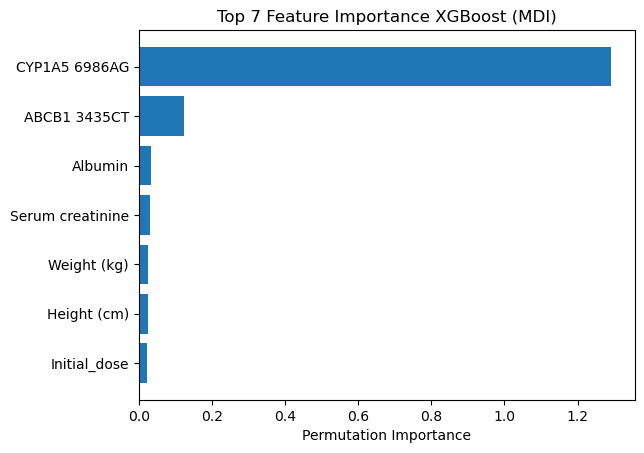

In [7]:
# Select the features to compute permutation importance for
features = ['Gender', 'Age', 'Height (cm)', 'Weight (kg)', 'Living donor', 'Hemoglobin', 'Leukocyte', 'Serum creatinine', 
                   'Total bilirubin', 'Albumin', 'Hypertension', 'Diabetes', 'Anemia', 'Cardiac insufficiency', 'Calcium channel blocker', 
                   'Metoprolol', 'Omeprazole', 'Furosemide', 'ACEI /ARA*', 'Cephalosporin ', 'Infected', 'Initial_dose',
                   'CYP1A5 6986AG', 'ABCB1 3435CT', 'ABCB1 129TC', 'ABCB1 1236CT', 'ABCB1 2677GT']

# Compute permutation importance for all features
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get sorted indices of feature importances
sorted_idx = result.importances_mean.argsort()

# Select top K features to plot
top_k = 7
fig, ax = plt.subplots()
ax.barh(np.arange(top_k), result.importances_mean[sorted_idx[-top_k:]], align='center')
ax.set_yticks(np.arange(top_k))
ax.set_yticklabels(np.array(features)[sorted_idx[-top_k:]])
ax.set_xlabel('Permutation Importance')
ax.set_title("Top %d Feature Importance XGBoost (MDI)" % top_k)
plt.show()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


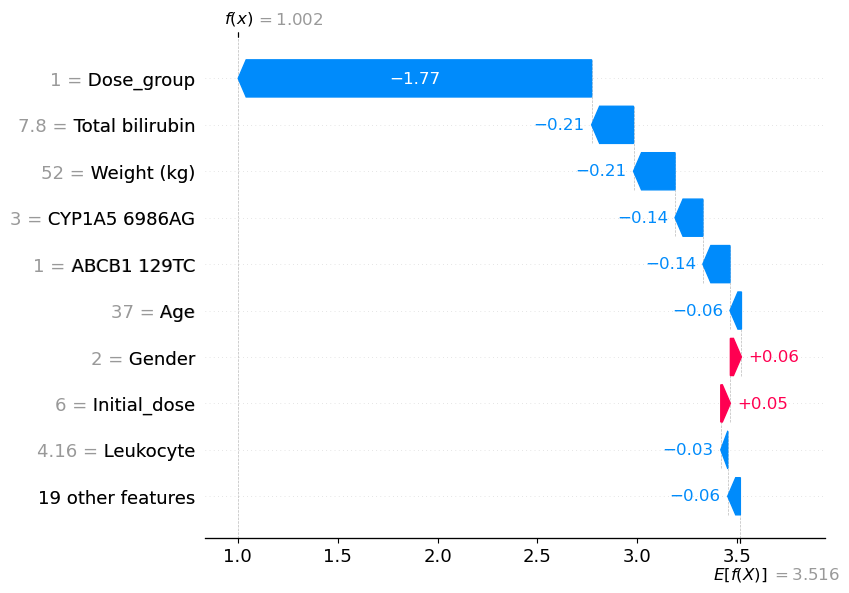

In [8]:
import shap

X_shap = rein_aug_df.drop(labels=['Stable_dose'],axis=1)

# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for all instances
shap_values = explainer(X_shap)

# Get the expected value of the model output
base_value = explainer.expected_value

# Plot the SHAP values for all instances
shap.waterfall_plot(shap_values[0])


In [9]:
import pickle 
pickle.dump(xgb_model,open('xgb_model.pkl','wb'))

xgb_model = pickle.load(open('xgb_model.pkl','rb'))
